In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from torch import optim
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torchmetrics.functional import structural_similarity_index_measure
from matplotlib.tri import Triangulation
from io import BytesIO

###  DataLoader

In [4]:
input_path = '/home/nn_unet_for_anh/Dataset/inputData1T_5K.xlsx'
output_folder = '/home/nn_unet_for_anh/Dataset/original-images'

In [11]:
def vector_to_matrix(vec, size=16):
    """
    Reshape a 240-measurement vector into a (1, size, size) matrix,
    with diagonal elements set to zero (blank), assuming measurements
    come from source-detector pairs excluding diagonal pairs (i ≠ j).
    Args:
        vec (torch.Tensor): Input vector of shape (240,) or (B, 240).
        size (int): Dimension of the output square matrix. Default is 16.
    Returns:
        torch.Tensor: Matrix of shape (1, size, size) or (B, 1, size, size)/
    """
    if vec.ndim == 1:
        mat = torch.zeros(1, size, size)
        idx = 0
        for i in range(size):
            for j in range(size):
                if i != j:
                    mat[0, i, j] = vec[idx]
                    idx += 1
    elif vec.ndim == 2:
        B = vec.shape[0]
        mat = torch.zeros((B, 1, size, size), dtype=vec.dtype, device=vec.device)
        idx = 0
        for i in range(size):
            for j in range(size):
                if i != j:
                    mat[:, 0, i, j] = vec[:, idx]
                    idx += 1
    else:
        # Raise error if input is not 1D or 2D with correct shape
        raise ValueError('vec must be shape (240,) or (B, 240)')
    return mat



class DOTDataset(Dataset):
    """
    PyTorch Dataset for loading DOT (Diffuse Optical Tomography) measurements
    and corresponding ground truth RGBA images.
    Args:
        input_path (str): Path to Excel file containing 240-element measurement vectors.
        output_folder (str): Folder path containing RGBA images named as {index}.png.
        device (torch.device): Device to load tensors onto (CPU or GPU).
        max_samples (int): Maximum number of samples to load.
    """
    def __init__(self,
                 input_path,
                 output_folder,
                 device=torch.device('cuda:3' if torch.cuda.is_available() else 'cpu'),
                 max_samples=5000):
        # Load and normalize measurement vectors
        self.inputs = torch.tensor(pd.read_excel(input_path, header=None).T.values[:max_samples].astype('float32'))
        self.inputs = self.inputs / self.inputs.max()
        self.output_folder = output_folder
        self.device = device

        # Image transforms
        self.resize = transforms.Resize((64, 64))
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Convert input vector to (1, 16, 16) matrix form
        x = self.inputs[idx].to(self.device)
        x_img = vector_to_matrix(x)

        # Load RGBA image
        y_rgba = Image.open(f'{self.output_folder}/{idx}.png').convert('RGBA')
        y_rgba = self.resize(y_rgba)

        # Convert to NumPy and normalize to [0, 1]
        y_np = np.array(y_rgba).astype(np.float32) / 255.0  # (H, W, 4)

        # Split into RGB and Alpha
        rgb = y_np[..., :3]     # (H, W, 3)
        alpha = y_np[..., 3:]   # (H, W, 1)

        # Create binary alpha mask: 1 for foreground, 0 for transparent background
        alpha_mask = (alpha > 0).astype(np.float32)  # shape: (H, W, 1)

        # Zero out RGB where alpha = 0 (transparent)
        rgb[alpha_mask.squeeze() == 0] = 0.0

        # Convert to PyTorch tensors (scaled back to 0–255 for transforms.ToTensor)
        rgb_tensor = self.to_tensor((rgb * 255).astype(np.uint8)).to(self.device)            # (3, 64, 64)
        alpha_tensor = self.to_tensor((alpha_mask * 255).astype(np.uint8)).to(self.device)   # (1, 64, 64)

        return x_img, rgb_tensor, alpha_tensor


def get_dataloaders(input_path, output_folder, batch_size=32, val_ratio=0.1, test_ratio=0.1):
    """
    Load the DOT dataset and split into train, validation, and test DataLoaders.

    Args:
        input_path (str): Path to Excel file with measurement vectors.
        output_folder (str): Folder containing corresponding RGBA images.
        batch_size (int): Batch size for the DataLoaders.
        val_ratio (float): Fraction of samples for validation set.
        test_ratio (float): Fraction of samples for test set.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: Train, validation, and test DataLoaders.
    """
    dataset = DOTDataset(input_path, output_folder, max_samples=5000)
    total = len(dataset)
    val_size = int(total * val_ratio)
    test_size = int(total * test_ratio)
    train_size = total - val_size - test_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [13]:
train_loader, val_loader, test_loader = get_dataloaders(input_path, output_folder, batch_size=64)

for x_batch, y_batch, _ in train_loader:
    print(x_batch.shape)    #expected: [B, 1, 16, 16] for 2D
    print(y_batch.shape)    #expected: [B, 3, H, W] for 2D
    break

torch.Size([64, 1, 16, 16])
torch.Size([64, 3, 64, 64])


### U-net Model

In [2]:
class DoubleConv(nn.Module):
    """
    Applies two consecutive convolutional layers each followed by
    batch normalization and ReLU activation.

    Structure:
        (Conv2d → BatchNorm2d → ReLU) × 2

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        mid_channels (int, optional): Number of intermediate channels after first conv.
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downsampling block that reduces spatial resolution by 2 using MaxPool,
    followed by a DoubleConv block.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upsampling block that increases spatial resolution by 2 using either
    bilinear upsampling or transposed convolution, then applies DoubleConv.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        bilinear (bool): Whether to use bilinear interpolation (True) or transposed convolution (False).
    """

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        #if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        """
        Forward pass for the upsampling block.

        Args:
            x1 (Tensor): The upsampled input tensor from the decoder path.
            x2 (Tensor): The corresponding skip connection from the encoder path.

        Returns:
            Tensor: Output after upsampling and convolution.
        """
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """
    Final output layer that maps features to the desired number of output channels.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels (e.g., 1 for grayscale map).
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1))

    def forward(self, x):
        return self.conv(x)

In [3]:
class Unet(nn.Module):
    """
    U-Net architecture for 2D image reconstruction in Diffuse Optical Tomography (DOT).

    The network uses a contracting path (encoder) followed by an expanding path (decoder),
    with skip connections between corresponding layers. Input shape is assumed to be (B, 1, 16, 16),
    and the output is upsampled to (B, 3, 64, 64), representing a 3-channel reconstructed image.

    Args:
        in_shape (tuple): Input spatial shape (height, width). Default is (16, 16).
        bilinear (bool): Whether to use bilinear upsampling (True) or transposed convolution (False).

    Returns:
        torch.Tensor: Reconstructed image with shape (B, 3, 64, 64), values in [0, 1].
    """
    def __init__(self, in_shape=(16, 16), bilinear=True):  #bilinear: True -> 2d, False -> 1d
        super(Unet, self).__init__()
        self.in_shape = in_shape
        self.bilinear = bilinear

        # Encoder
        self.inc = DoubleConv(1, 128)
        self.down1 = Down(128, 256)
        self.down2 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down3 = Down(512, 1024 // factor)

        # Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.outc = OutConv(128, 3)


    def forward(self, x):
        # Encoder
        x1 = self.inc(x)            # -> (B, 128, 16, 16)
        x2 = self.down1(x1)         # -> (B, 256, 8, 8)
        x3 = self.down2(x2)         # -> (B, 512, 4, 4)
        x4 = self.down3(x3)         # -> (B, 1024, 2, 2)

        # Decoder
        x = self.up1(x4, x3)        # -> (B, 512, 4, 4)
        x = self.up2(x, x2)         # -> (B, 256, 8, 8)
        x = self.up3(x, x1)         # -> (B, 128, 16, 16)
        out = self.outc(x)          # -> (B, 3, 16, 16)

        # Final output
        out = F.interpolate(out, size=(64, 64), mode='bilinear', align_corners=True)
        out = torch.sigmoid(out)
        return out

### Training Loop

#### Loss

In [20]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.3, fg_weight=5):
    """
    Custom loss function combining weighted MSE and SSIM for image reconstruction tasks.

    The total loss is a weighted sum of:
        - Foreground-aware Weighted MSE (foreground pixels penalized more)
        - Structural Similarity Index Measure (SSIM)

    total_loss = (1 - alpha) * weighted_MSE + alpha * (1 - SSIM)

    Args:
        alpha (float): Weight for the SSIM loss component. Should be between 0 and 1.
        fg_weight (float): Weight multiplier for foreground pixel errors in MSE.
    """
        super().__init__()
        self.alpha = alpha
        self.fg_weight = fg_weight

    def forward(self, y_pred, y_true):
        """
        Compute the combined loss between predicted and ground truth RGB images.

        Args:
            y_pred (torch.Tensor): Predicted images, shape (B, 3, H, W), values in [0, 1].
            y_true (torch.Tensor): Ground truth images, shape (B, 3, H, W), values in [0, 1].

        Returns:
            torch.Tensor: Scalar total loss.
        """
        # Use RGB directly for SSIM
        y_true_rgb = y_true
        y_pred_rgb = y_pred

        # Convert to grayscale to compute foreground mask
        y_true_gray = y_true.mean(dim=1, keepdim=True)
        y_pred_gray = y_pred.mean(dim=1, keepdim=True)


        # SSIM Loss
        ssim = structural_similarity_index_measure(y_pred_rgb, y_true_rgb, data_range=1)
        ssim_loss = 1 - ssim

        # Define foreground mask
        mask = (y_true_gray > 0.010).float()   # (B, 1, H, W). Note: 0.10 is cutoff for black phantom background.
        mask = mask.repeat(1, 3, 1, 1)        # (B, 3, H, W) -> repeat the mask for all 3 channels.
        
        # Weighted MSE
        fg_mse = (mask * (y_pred_rgb - y_true_rgb)**2).mean()
        bg_mse = ((1 - mask) * (y_pred_rgb - y_true_rgb)**2).mean()
        weighted_mse = self.fg_weight * fg_mse + bg_mse

        # Total Combined Loss
        total_loss = (1 - self.alpha) * weighted_mse + self.alpha * ssim_loss
        return total_loss

#### Train

In [44]:
def train_model(model,
                train_loader,
                val_loader,
                num_epochs=50,
                batch_size=64,
                lr=1e-3,
                weight_decay=1e-8,
                device='cuda:4' if torch.cuda.is_available() else 'cpu'):
    """
    Train a U-Net model for image reconstruction using CombinedLoss (weighted MSE + SSIM).

    Args:
        model (torch.nn.Module): U-Net model to be trained.
        train_loader (DataLoader): DataLoader for training set.
        val_loader (DataLoader): DataLoader for validation set.
        num_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization).
        device (str): Device to train on ('cuda:X' or 'cpu').

    Returns:
            - Trained model
            - List of training losses per epoch
            - List of validation losses per epoch
    """

    print(f'''Starting training:
                Epochs:        {num_epochs}
                Batch size:    {batch_size}
                Learning rate: {lr}
                Weight decay:  {weight_decay}
                ''')

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
    criterion = CombinedLoss(alpha=0.2, fg_weight=75)
    
    
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        #-------Training---------
        model.train()
        train_loss=0
        for x_batch, y_batch, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().item() * x_batch.size(0)

        train_loss /= len(train_loader.dataset)

        #-------Validation---------
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch, _ in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * x_batch.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Periodic logging and checkpointing
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
            
            os.makedirs("outputs", exist_ok=True)
            torch.save(model.state_dict(), f'outputs/epoch_{epoch + 1}_model.pth')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Best model saved')

    print('Training Complete')
    return model, train_losses, val_losses

Starting training:
                Epochs:        200
                Batch size:    64
                Learning rate: 0.005
                Weight decay:  0
                


Best model saved


Epoch 10/200 | Train Loss: 0.160499 | Val Loss: 0.381549


Best model saved


Epoch 20/200 | Train Loss: 0.122774 | Val Loss: 0.384879


Epoch 30/200 | Train Loss: 0.083099 | Val Loss: 0.295264


Epoch 40/200 | Train Loss: 0.075056 | Val Loss: 0.333161


Epoch 50/200 | Train Loss: 0.070473 | Val Loss: 0.388482


Best model saved


Best model saved


Epoch 60/200 | Train Loss: 0.070204 | Val Loss: 0.347858


Best model saved


Epoch 70/200 | Train Loss: 0.067809 | Val Loss: 0.318718


Epoch 80/200 | Train Loss: 0.068083 | Val Loss: 0.159722


Best model saved


Best model saved


Epoch 90/200 | Train Loss: 0.068508 | Val Loss: 0.085592


Epoch 100/200 | Train Loss: 0.067101 | Val Loss: 0.197722


Epoch 110/200 | Train Loss: 0.068573 | Val Loss: 0.226537


Epoch 120/200 | Train Loss: 0.068999 | Val Loss: 0.234149


Epoch 130/200 | Train Loss: 0.068536 | Val Loss: 0.165121


Epoch 140/200 | Train Loss: 0.068576 | Val Loss: 0.222804


Epoch 150/200 | Train Loss: 0.068197 | Val Loss: 0.200570


Epoch 160/200 | Train Loss: 0.067802 | Val Loss: 0.171815


Epoch 170/200 | Train Loss: 0.068698 | Val Loss: 0.236201


Epoch 180/200 | Train Loss: 0.068446 | Val Loss: 0.248909


Epoch 190/200 | Train Loss: 0.068397 | Val Loss: 0.093972


Epoch 200/200 | Train Loss: 0.068475 | Val Loss: 0.171177
Training Complete


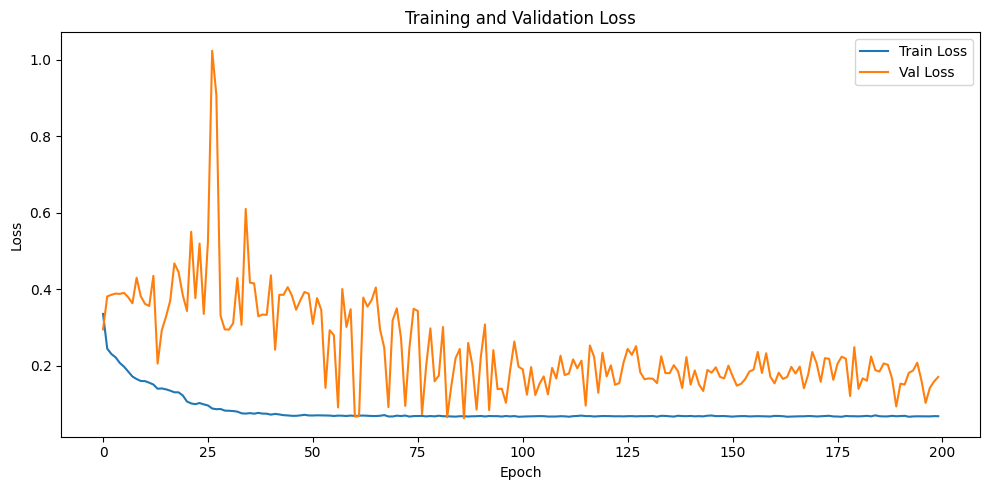

<Figure size 640x480 with 0 Axes>

In [45]:
model = Unet(bilinear=True)

trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=200, lr=5e-3, weight_decay=0)

# Display the figure
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Save the figure
os.makedirs("outputs", exist_ok=True)
plt.savefig("outputs/learning_curve_Unet.png")
plt.show()

### Testing Loop

In [23]:
def _ssim_global(x: np.ndarray,
                 y: np.ndarray,
                 c1: float = 1e-4,
                 c2: float = 1e-4) -> float:
    """
    Global‑mean SSIM as
        (2 μ_x μ_y + c1)(2 σ_xy + c2)
    -----------------------------------
        (μ_x² + μ_y² + c1)(σ_x² + σ_y² + c2)

    • Works for 2‑D (H×W) or 3‑D (H×W×C) arrays.
    • For colour images each channel is scored
      independently and the mean is returned.
    """
    if x.ndim == 3:                      # H × W × C
        μ_x  = x.mean(axis=(0, 1))
        μ_y  = y.mean(axis=(0, 1))
        σ_x2 = x.var(axis=(0, 1))
        σ_y2 = y.var(axis=(0, 1))
        σ_xy = ((x - μ_x) * (y - μ_y)).mean(axis=(0, 1))
        ssim_c = ((2 * μ_x * μ_y + c1) * (2 * σ_xy + c2)) / \
                 ((μ_x**2 + μ_y**2 + c1) * (σ_x2 + σ_y2 + c2))
        return float(ssim_c.mean())      # average over channels
    else:                                # 1‑D or 2‑D
        μ_x  = x.mean()
        μ_y  = y.mean()
        σ_x2 = x.var()
        σ_y2 = y.var()
        σ_xy = ((x - μ_x) * (y - μ_y)).mean()
        return float(((2 * μ_x * μ_y + c1) * (2 * σ_xy + c2)) /
                     ((μ_x**2 + μ_y**2 + c1) * (σ_x2 + σ_y2 + c2)))

In [24]:
import numpy as np
from skimage.metrics import structural_similarity
from skimage.draw import disk

def compute_metrics(y_true, y_pred):
    """
    Compute image reconstruction quality metrics between predicted and ground truth images,
    restricted to a circular region of interest (ROI) in the center.

    Metrics calculated:
        - ABE (Absolute Bias Error)
        - MSE (custom variant)
        - MSE-S (standard MSE)
        - PSNR (custom variant)
        - PSNR-S (standard PSNR)
        - SSIM (Structural Similarity Index)

    Args:
        y_true (torch.Tensor): Ground truth image tensor, shape (1, H, W) or (3, H, W)
        y_pred (torch.Tensor): Predicted image tensor, shape (1, H, W) or (3, H, W)

    Returns:
        dict: Dictionary containing scalar values for all computed metrics.
    """
    y_true = y_true.detach().cpu().numpy().squeeze()
    y_pred = y_pred.detach().cpu().numpy().squeeze()

    if y_true.ndim == 3 and y_true.shape[0] == 3:
        y_true = np.moveaxis(y_true, 0, -1)
        y_pred = np.moveaxis(y_pred, 0, -1)

    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)

    # --- Create circular mask ---
    h, w = y_true.shape[:2]
    center = (h // 2, w // 2)
    radius = min(h, w) // 2 - 2  # subtract margin to avoid border

    mask = np.zeros((h, w), dtype=bool)
    rr, cc = disk(center, radius, shape=mask.shape)
    mask[rr, cc] = True

    if y_true.ndim == 3:  # RGB
        mask = mask[..., None]
        mask = np.repeat(mask, 3, axis=2)

    # --- Apply mask ---
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # --- Metrics ---
    # SSIM
    ssim = _ssim_global(y_true_masked, y_pred_masked)

    # Flatten for scalar metrics
    y_true_flat = y_true_masked.flatten()
    y_pred_flat = y_pred_masked.flatten()

    # ABE
    abe = np.mean(np.abs(y_true_flat - y_pred_flat))

    # MSE and MSE-S
    y_pred_mean = np.mean(y_pred_flat)
    var = np.mean(np.abs(y_true_flat - y_pred_mean))
    mse = abe**2 + var
    mse_s = np.mean(np.square(y_true_flat - y_pred_flat))

    # PSNR
    max_val = np.max(y_pred_flat)
    psnr = 10 * np.log10((max_val**2) / mse) if mse > 0 else float('inf')
    psnr_s = 10 * np.log10((max_val**2) / mse_s) if mse_s > 0 else float('inf')

    return {
        'ABE': abe,
        'MSE': mse,
        'MSE-S': mse_s,
        'PSNR': psnr,
        'PSNR-S': psnr_s,
        'SSIM': ssim
    }


#### Evaluate

In [25]:
def evaluate_model_mean(model, test_loader, device='cuda:4' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate a trained model on the test set and compute average performance metrics.
    The function prints the mean and standard deviation of each metric across the test set.

    Args:
        model (torch.nn.Module): Trained PyTorch model to be evaluated.
        test_loader (DataLoader): DataLoader containing test samples.
        device (str): Device to run inference on ('cuda' or 'cpu').
    """
    model = model.to(device)
    model.eval()

    all_metrics ={
        'ABE': [],
        'MSE': [],
        'MSE-S': [],
        'PSNR': [],
        'PSNR-S': [],
        'SSIM': [],
    }

    with torch.no_grad():
      for x_batch, y_batch, _ in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)

        for i in range(x_batch.size(0)):
          metrics = compute_metrics(y_batch[i], output[i])
          for key, value in metrics.items():
            all_metrics[key].append(value)

    for key, value in all_metrics.items():
      mean = np.mean(value)
      std = np.std(value)
      print(f'{key}: {mean:.4f} ± {std:.4f}')

In [50]:
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model_mean(model, test_loader)

ABE: 0.0080 ± 0.0030
MSE: 0.0299 ± 0.0136
MSE-S: 0.0014 ± 0.0011
PSNR: 12.7958 ± 1.7896
PSNR-S: 26.9347 ± 2.6109
SSIM: 0.9508 ± 0.0178
SSIM-G: 0.8807 ± 0.0750


#### Save predictions

In [51]:
def save_predictions(model, test_loader, device='cuda:4' if torch.cuda.is_available() else 'cpu',
                     prediction_dir='prediction', ground_truth_dir='ground_truth'):
     """
    Save predicted and ground truth RGBA images from a trained model using a test DataLoader.

    For each test sample:
        - Predict RGB output using the model
        - Apply the alpha mask
        - Convert to RGBA image
        - Save both prediction and ground truth as .png files

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        test_loader (DataLoader): DataLoader yielding (x, y_true, alpha_mask) samples.
        device (str): Device for inference (default: 'cuda:4' or 'cpu').
        prediction_dir (str): Directory to save predicted images.
        ground_truth_dir (str): Directory to save ground truth images.
    """

    model = model.to(device)
    model.eval()

    os.makedirs(prediction_dir, exist_ok=True)
    os.makedirs(ground_truth_dir, exist_ok=True)

    all_y_true = []
    all_y_pred = []
    sample_idx = 0

    with torch.no_grad():
        for x_batch, y_batch, alpha_mask in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            alpha_mask = alpha_mask.to(device)
            
            preds = model(x_batch)

            for i in range(x_batch.size(0)):
                pred = preds[i].cpu()
                true = y_batch[i].cpu()
                alpha = alpha_mask[i].cpu()

                # Convert to numpy (3, H, W) -> (H, W, 3)
                pred_np = (pred.clamp(0, 1).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                true_np = (true.clamp(0, 1).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                alpha_np = (alpha.clamp(0, 1).squeeze().numpy() * 255).astype(np.uint8)  # (H, W)

                # Stack RGBA: (H, W, 4)
                pred_rgba = np.dstack((pred_np, alpha_np))
                true_rgba = np.dstack((true_np, alpha_np))

                # Save as RGBA PNG with transparent background
                Image.fromarray(pred_rgba).save(os.path.join(prediction_dir, f"pred_{sample_idx}.png"))
                Image.fromarray(true_rgba).save(os.path.join(ground_truth_dir, f"gt_{sample_idx}.png"))


                sample_idx += 1

In [52]:
model.load_state_dict(torch.load("best_model.pth"))
save_predictions(model, test_loader)

### Display Prediction vs Ground Truth Images

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_prediction_vs_ground_truth(model, test_loader, device='cuda:4' if torch.cuda.is_available() else 'cpu', n_samples=10):
    """
    Display side-by-side visual comparisons of predicted vs. ground truth RGBA images.

    Args:
        model (torch.nn.Module): Trained PyTorch model for image reconstruction.
        test_loader (DataLoader): DataLoader providing test samples as (input, target, alpha).
        device (str): Device for inference ('cuda:X' or 'cpu').
        n_samples (int): Number of sample predictions to display.
    """
    model = model.to(device)
    model.eval()

    shown = 0
    with torch.no_grad():
        for x_batch, y_batch, alpha_mask in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            alpha_mask = alpha_mask.to(device)

            preds = model(x_batch)

            for i in range(min(n_samples, x_batch.size(0))):
                # Get tensors
                pred = preds[i].clamp(0, 1).cpu()
                true = y_batch[i].clamp(0, 1).cpu()
                alpha = alpha_mask[i].clamp(0, 1).cpu()

                # Convert to numpy
                pred_np = (pred.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # (H, W, 3)
                true_np = (true.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # (H, W, 3)
                alpha_np = (alpha.squeeze().numpy() * 255).astype(np.uint8)       # (H, W)

                # Create RGBA images
                pred_rgba = np.dstack((pred_np, alpha_np))  # (H, W, 4)
                true_rgba = np.dstack((true_np, alpha_np))  # (H, W, 4)

                # Plot
                fig, axs = plt.subplots(1, 2, figsize=(15, 5))

                axs[0].imshow(true_rgba)
                axs[0].set_title('Ground Truth')
                axs[0].axis('off')

                axs[1].imshow(pred_rgba)
                axs[1].set_title('Prediction')
                axs[1].axis('off')

                plt.tight_layout()
                plt.show()

                shown += 1
                if shown >= n_samples:
                    return


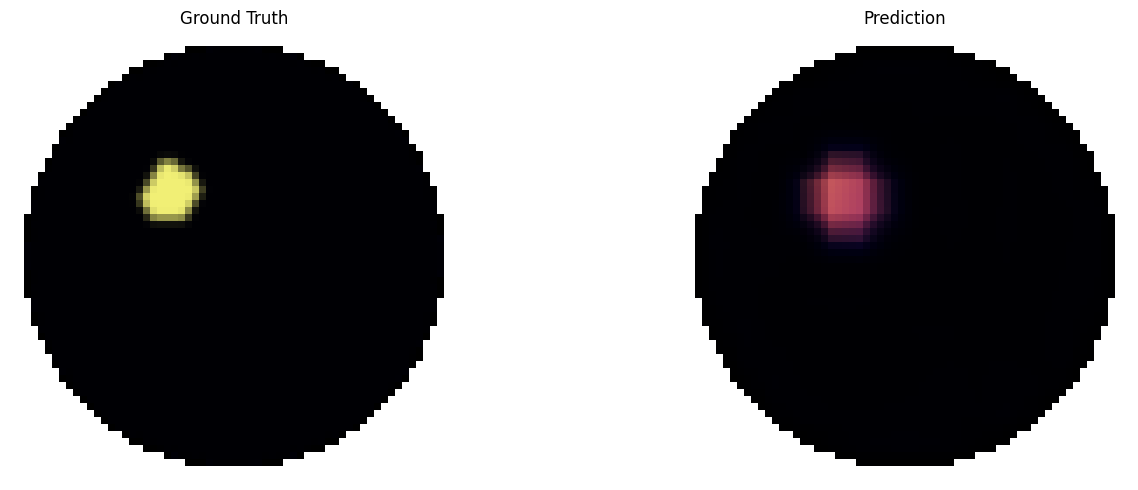

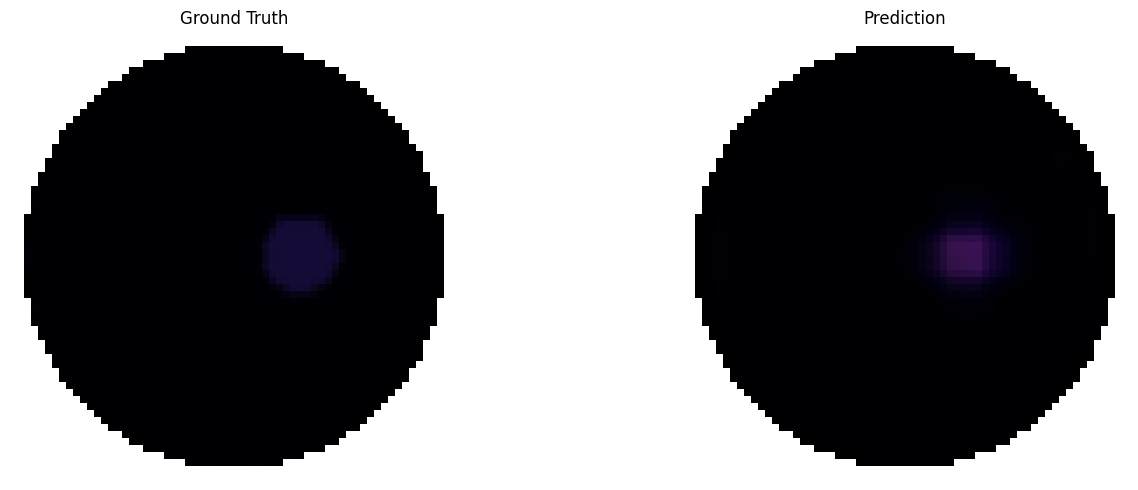

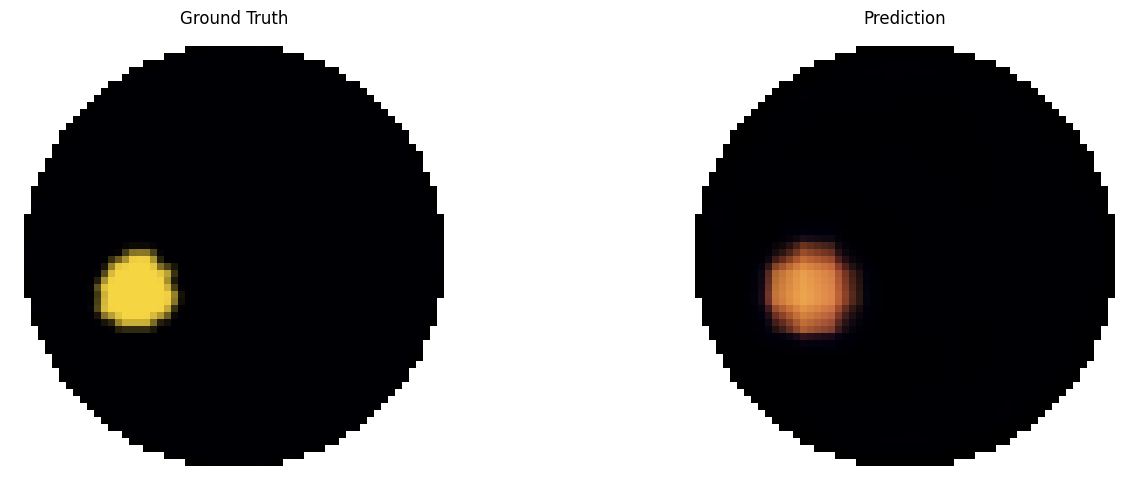

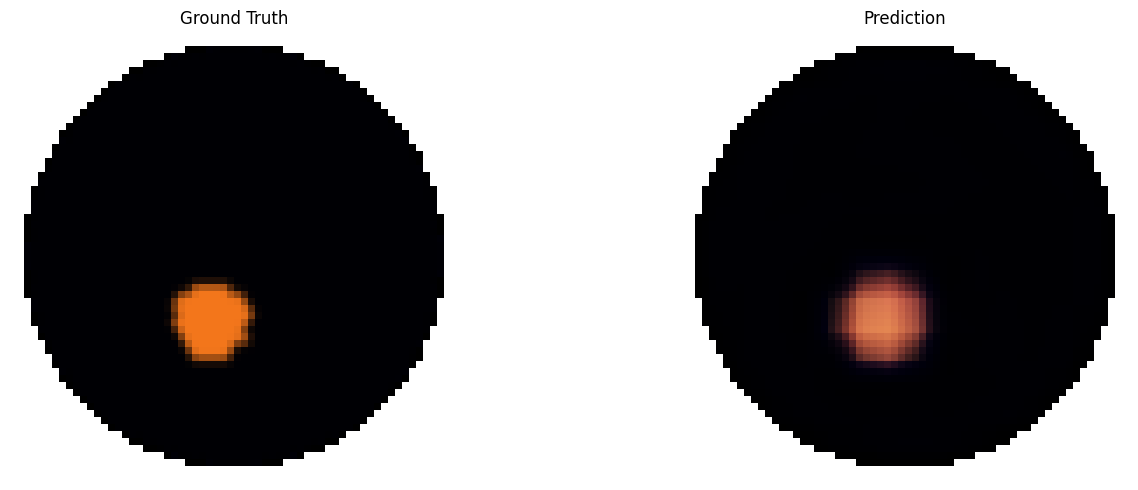

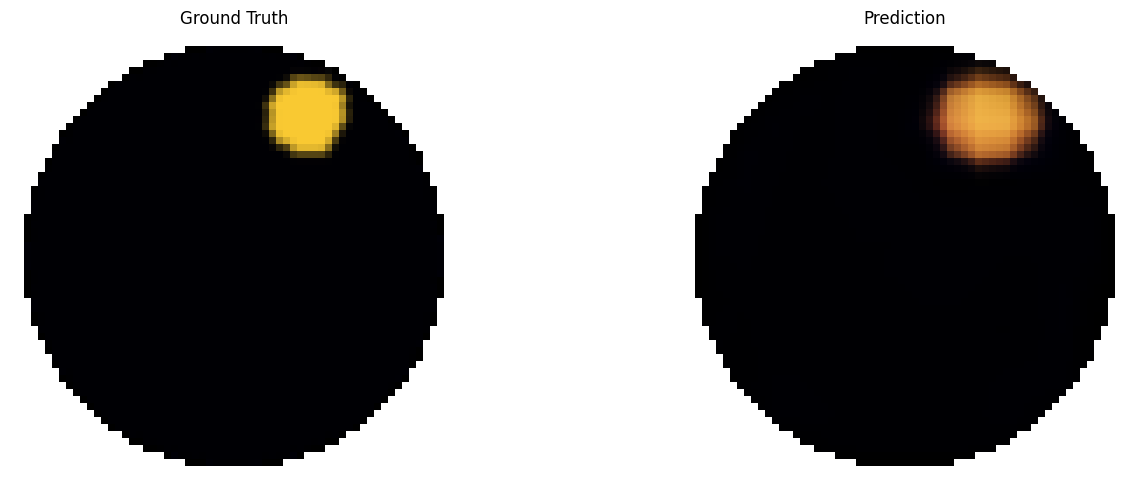

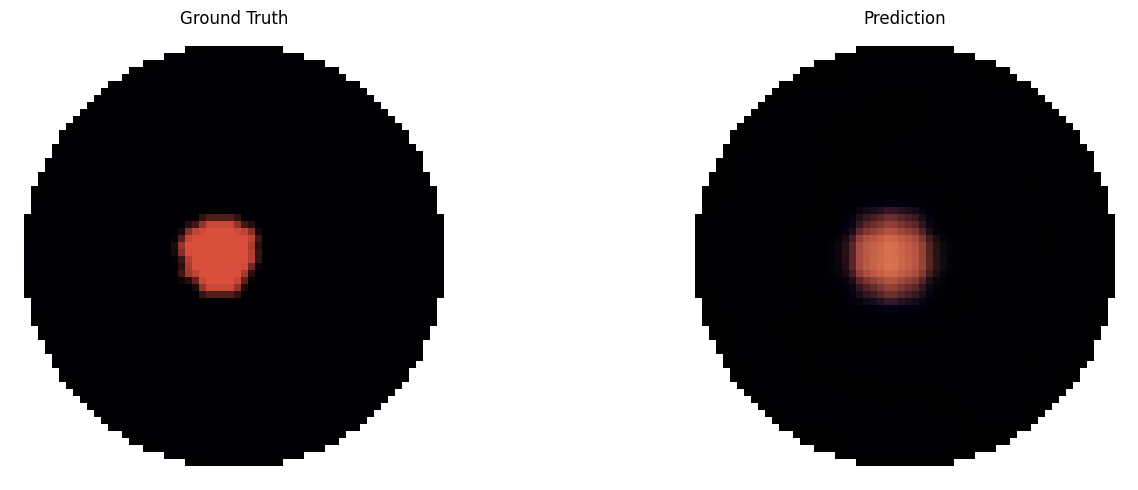

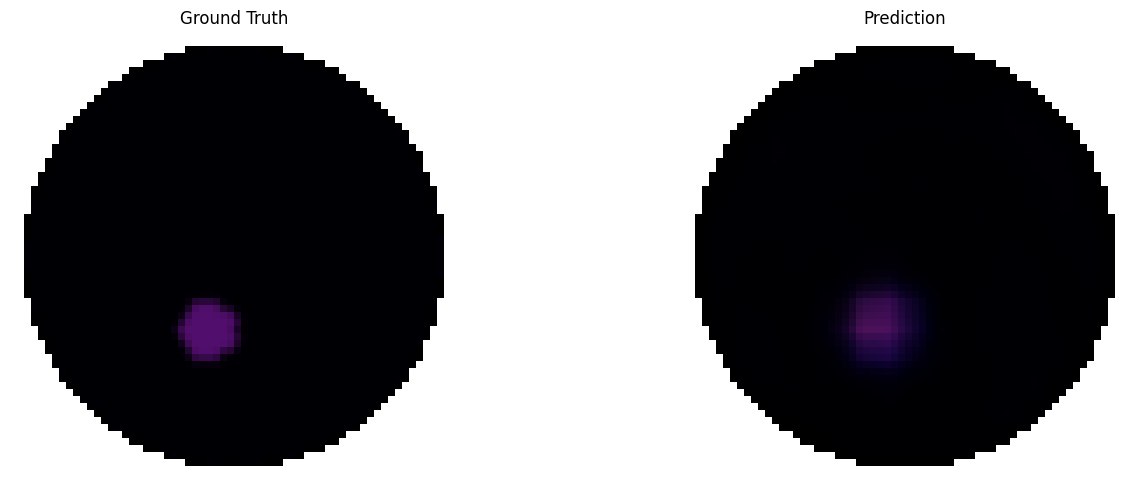

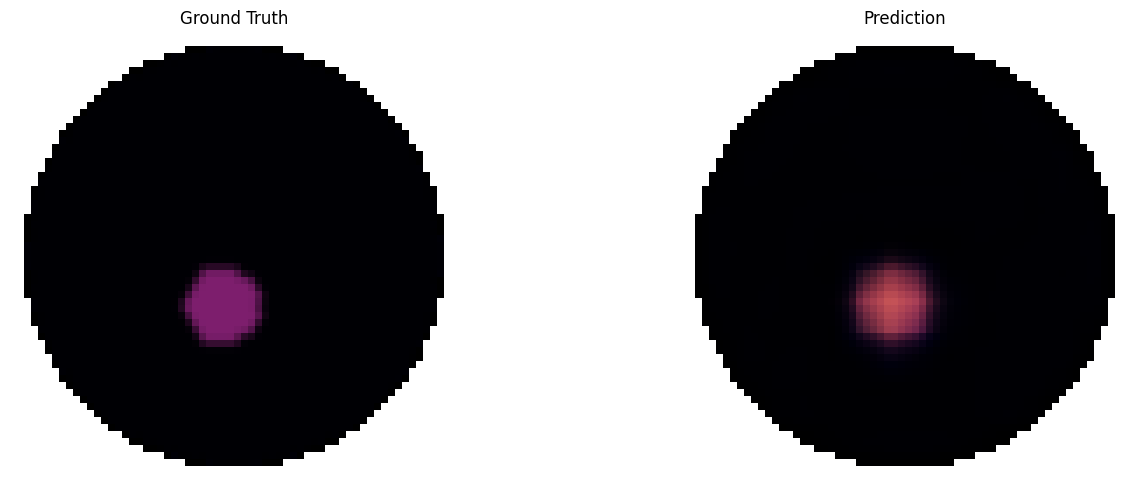

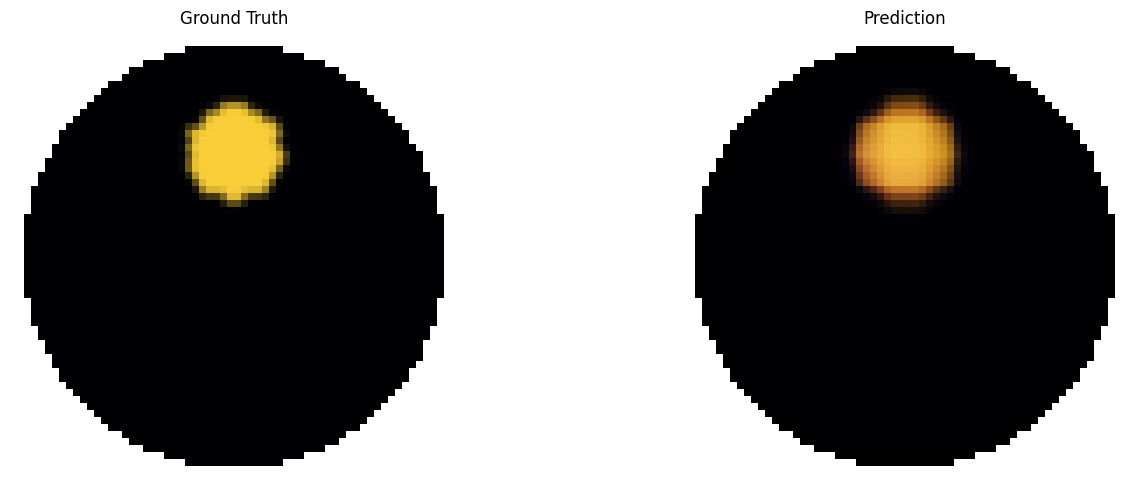

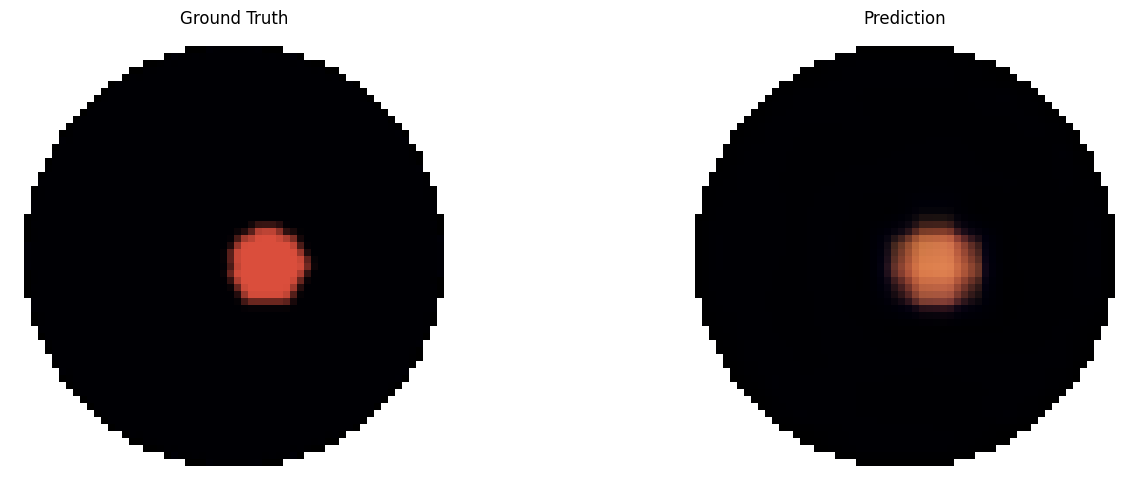

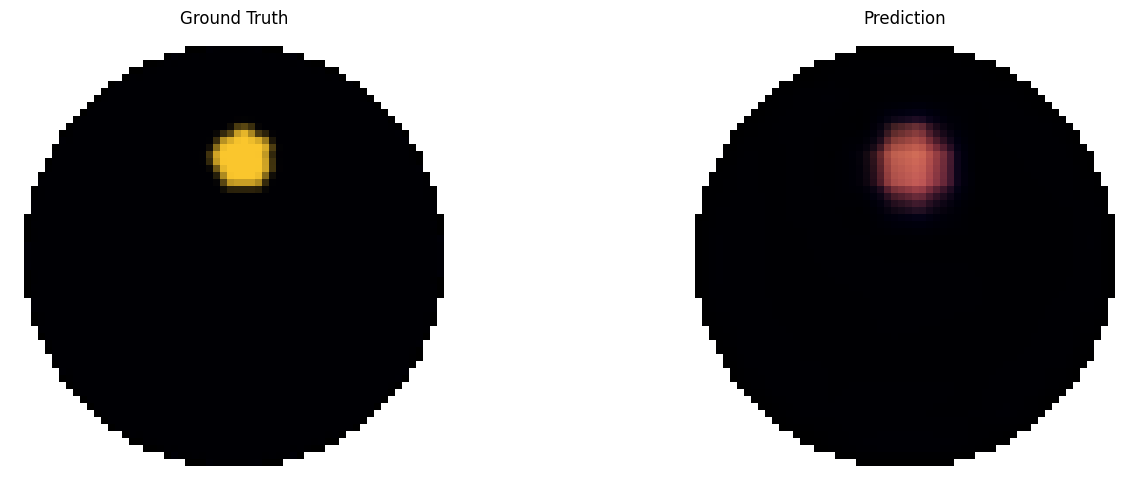

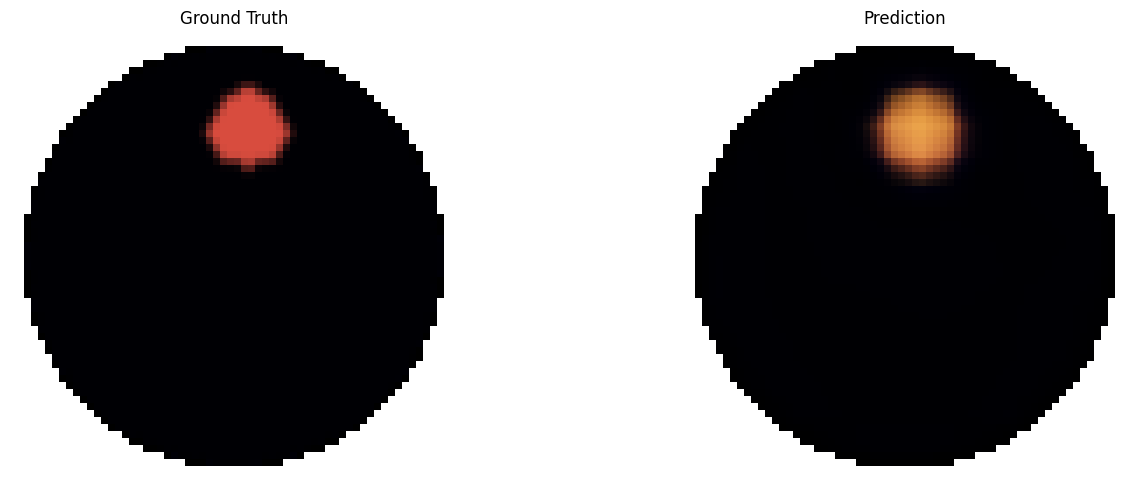

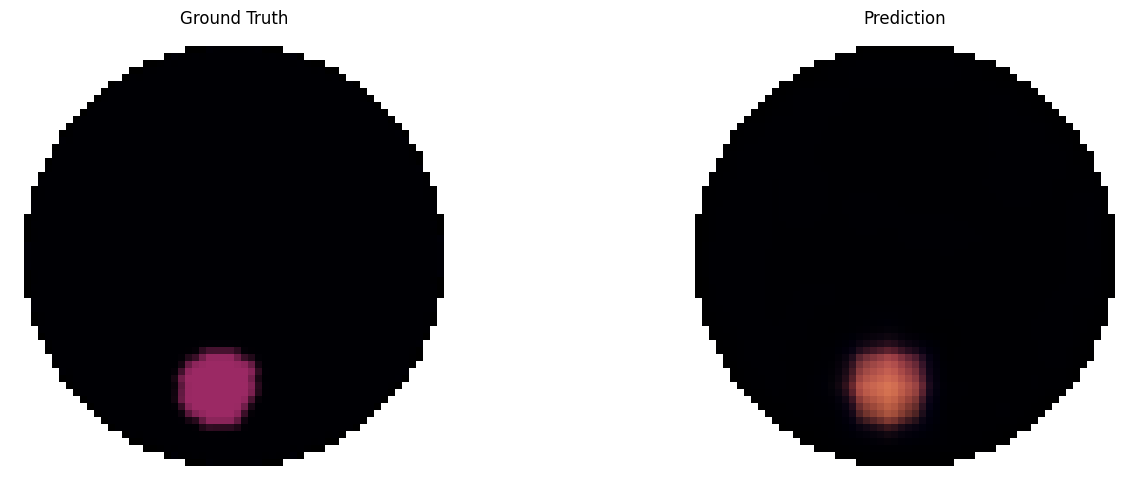

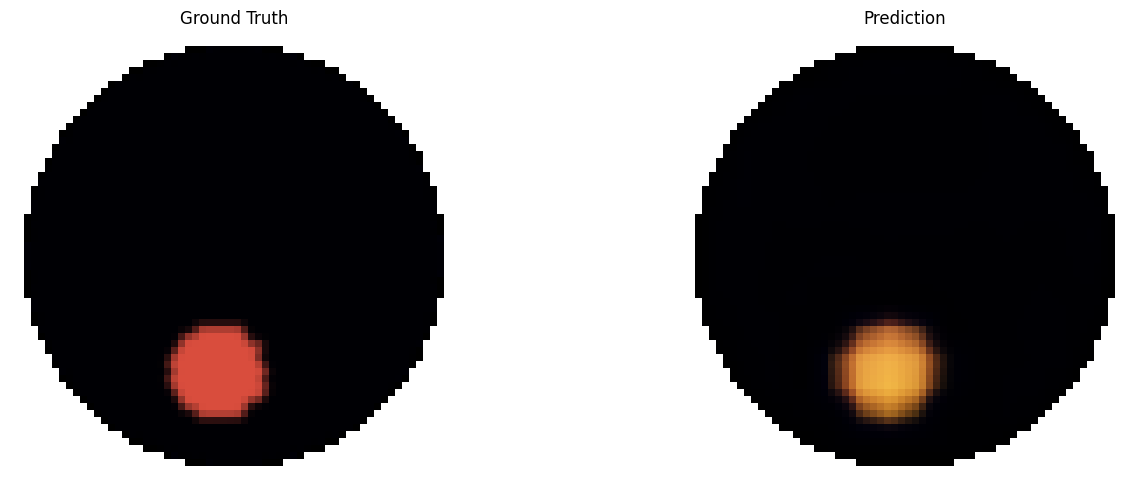

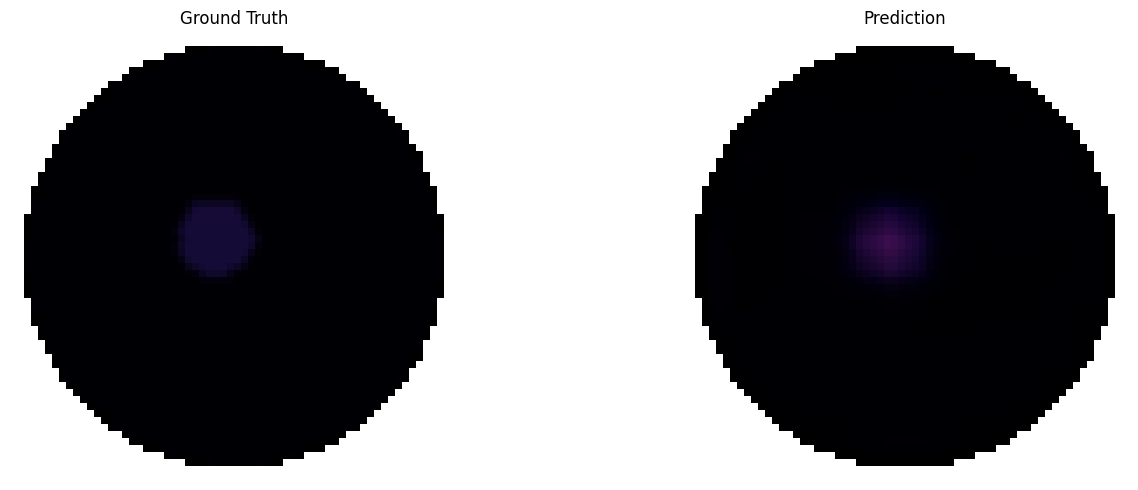

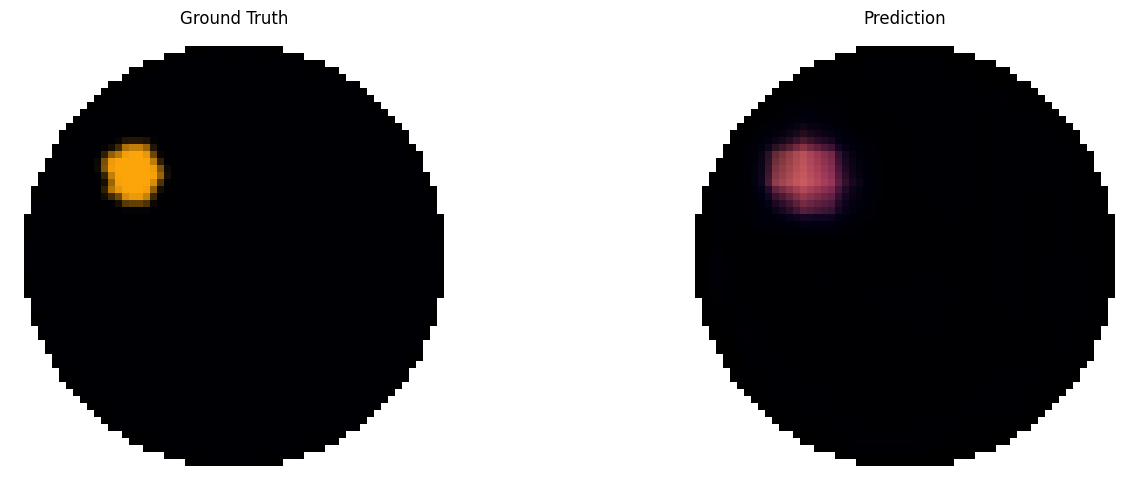

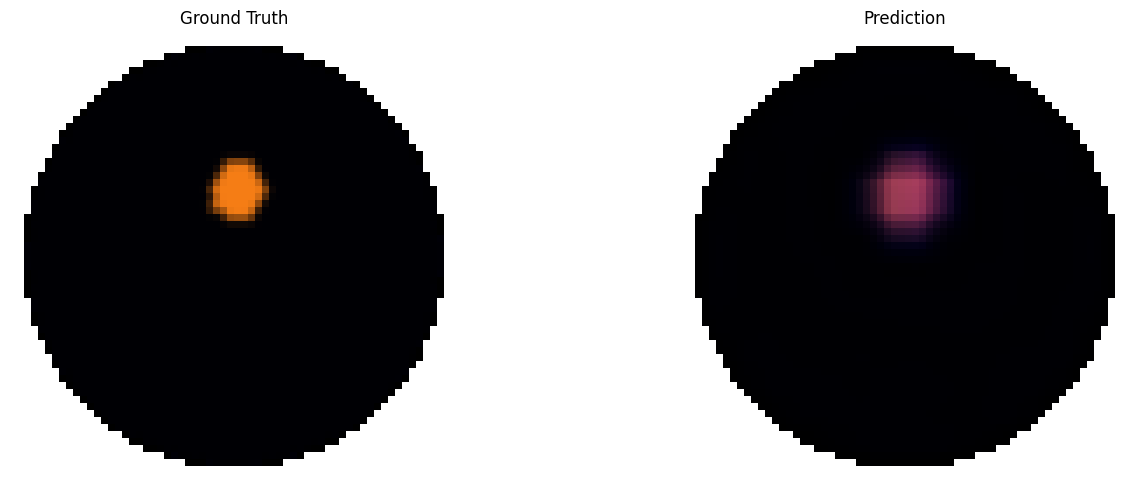

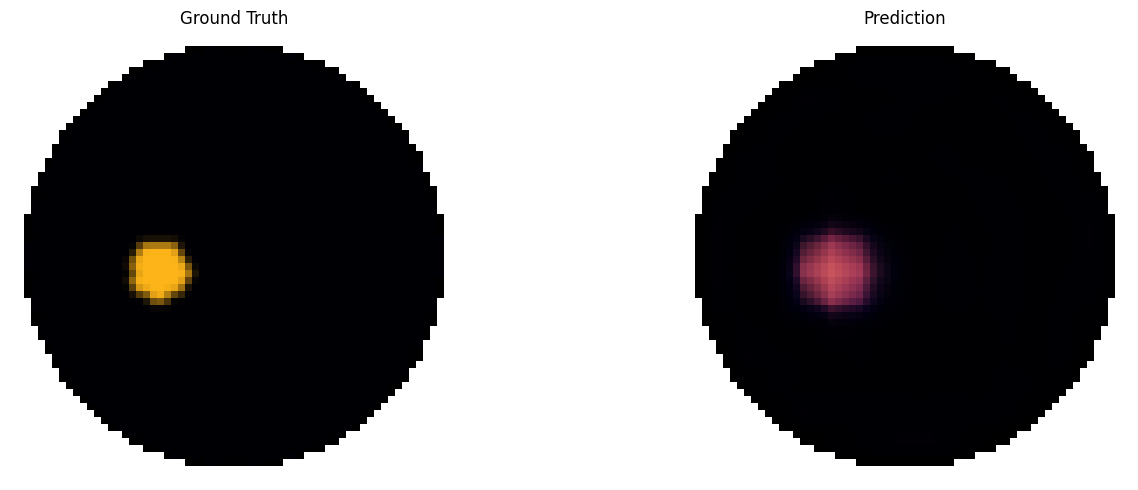

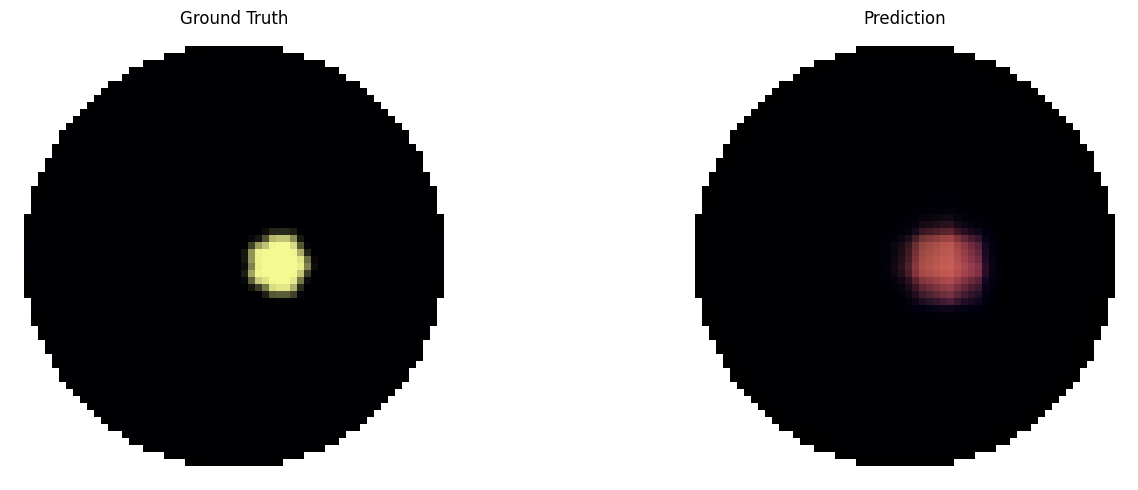

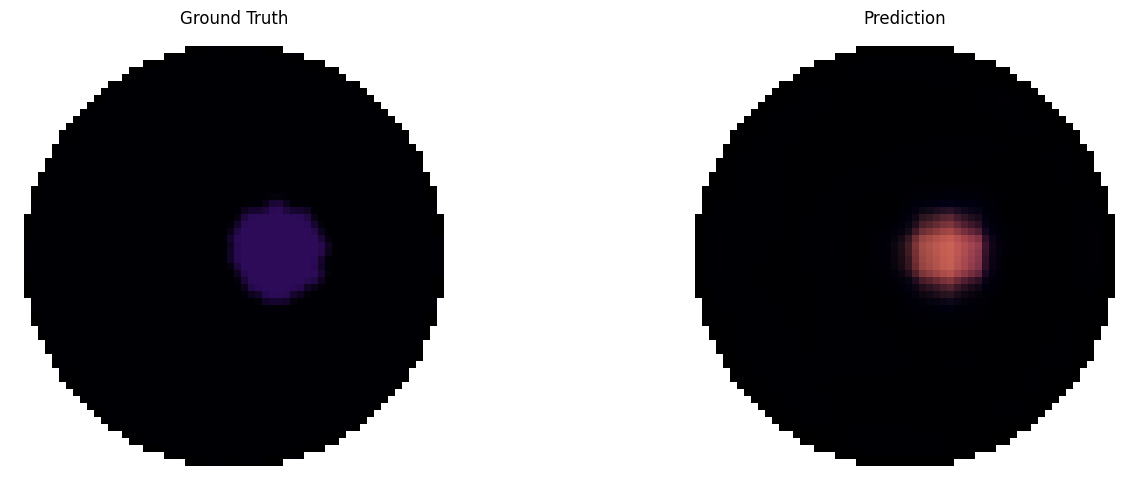

In [49]:
model.load_state_dict(torch.load('best_model.pth'))
show_prediction_vs_ground_truth(model, test_loader, n_samples=20)